# LSTM XOR
We want to implement an LSTM-RNN in TF to predict the XOR operation over a sequence of fixed length (for now) of bits.
First we need to generate these sequences and to compute the XOR itself.

Remarks:
- The XOR operation has a non-linear decision hyperplane

In [78]:
import tensorflow as tf
import numpy as np
from tqdm import tnrange
import matplotlib.pyplot as plt

## Generating sequences
We generate a dataset of N sequences of length L. These sequences are bit strings.
We also compute the XOR of the sequence directly.

In [190]:
LENGTH = 10
TRAIN_SAMPLES = 10000
TEST_SAMPLES = 10000

def xor(seq):
    return int(sum(seq) % 2 == 1)

Xtrain, Ytrain, Xtest, Ytest = [], [], [], []
for i in range(TRAIN_SAMPLES):
    seq = np.random.randint(0,2,LENGTH)
    Xtrain.append(seq)
    Ytrain.append(xor(seq))
for i in range(TEST_SAMPLES):
    seq = np.random.randint(0,2,LENGTH)
    Xtest.append(seq)
    Ytest.append(xor(seq))

## Building the model
Now we want to build a model which is able to compute the XOR of the sequence using an LSTM-RNN.

In [220]:
tf.reset_default_graph()

input_sequence = tf.placeholder(tf.float32, shape=(None, LENGTH))
input_sequence_3d = tf.reshape(input_sequence, (-1, LENGTH, 1))
results = tf.placeholder(tf.uint8, shape=(None, ))
results_oh = tf.one_hot(results, 2)
lstm = tf.contrib.rnn.BasicLSTMCell(2)

outputs, states = tf.nn.dynamic_rnn(lstm, input_sequence_3d, dtype=tf.float32)

final_output = outputs[:, -1]
predictions = tf.argmax(final_output, axis=1)

loss = tf.losses.softmax_cross_entropy(results_oh, final_output)
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [221]:
BATCH_SIZE = 64

losses = []
for epoch in tnrange(20):
    _losses = []
    for batch_index in range(0, len(Xtrain), BATCH_SIZE):
        Xbatch = Xtrain[batch_index:batch_index + BATCH_SIZE]
        Ybatch = Ytrain[batch_index:batch_index + BATCH_SIZE]
        _loss, _fout, _ = sess.run([loss, final_output, train_op], feed_dict={input_sequence: Xbatch, results: Ybatch})
        _losses.append(_loss)
    losses.append(np.mean(_losses))

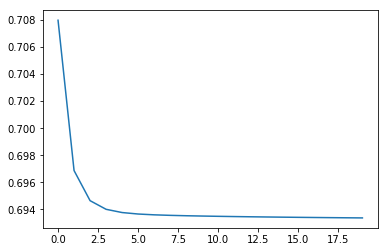

In [222]:
plt.plot(losses)
plt.show()

## Testing things out
We now compare the accuracy of the model on the train set and test set

In [204]:
acc = 0
for batch_index in range(0, len(Xtest), BATCH_SIZE):
    preds = sess.run(predictions, feed_dict={input_sequence: Xtest[batch_index:batch_index+BATCH_SIZE]})
    acc += sum(abs(preds - Ytest[batch_index:batch_index+BATCH_SIZE]))
print(acc / len(Ytest))

0.505


In [200]:
s, e = 0, 30
preds = sess.run(predictions, feed_dict={input_sequence: Xtest[s:e]})
print(abs(preds-Ytest[s:e]))
print(list(preds))
print(Ytest[s:e])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1]
[1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]


In [117]:
Ybatch

[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]